In [2]:
import pandas as pd

#Read in full dataset
data = pd.read_csv('../dnn/language_identification/data/sentences.csv',
                            sep='\t', 
                            encoding='utf8', 
                            index_col=0,
                            names=['lang','text'])

In [3]:
lang = ['eng']
data = data[data['lang'].isin(lang)]

In [17]:
#Filter by text length
#len_cond = [True if 20<=len(s)<=200 else False for s in data['text']]
#data = data[len_cond]

#Filter by text language
#lang = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']
#data = data[data['lang'].isin(lang)]

#Select 50000 rows for each language
data_trim = pd.DataFrame(columns=['lang','text'])

for l in lang:
    lang_trim = data[data['lang'] ==l].sample(15000,random_state = 100)
    data_trim = data_trim.append(lang_trim)

In [4]:
hin_data = pd.read_csv('../dnn/dakshina_dataset_v1.0/hi/romanized/hi.romanized.rejoined.tsv',
                            sep='\t', 
                            encoding='utf8',
                            usecols=[1],
                            names=['text'])

In [5]:
hin_data['lang'] = 'hi'

In [6]:
print(hin_data.shape)

(9949, 2)


In [8]:
tel_data = pd.read_csv('../dnn/dakshina_dataset_v1.0/te/romanized/te.romanized.rejoined.tsv',
                            sep='\t', 
                            encoding='utf8',
                            usecols=[1],
                            names=['text'])

In [9]:
tel_data['lang'] = 'te'

In [10]:
print(tel_data.shape)

(9920, 2)


In [14]:
tam_data = pd.read_csv('../dnn/dakshina_dataset_v1.0/ta/romanized/ta.romanized.rejoined.tsv',
                            sep='\t', 
                            encoding='utf8',
                            usecols=[1],
                            names=['text'])

In [15]:
tam_data['lang'] = 'ta'

In [16]:
print(tam_data.shape)

(9904, 2)


In [18]:
data_trim = data_trim.append(tel_data,ignore_index=True)
print(data_trim.shape)

(24920, 2)


In [19]:
data_trim = data_trim.append(hin_data,ignore_index=True)
print(data_trim.shape)

(34869, 2)


In [20]:
data_trim = data_trim.append(tam_data,ignore_index=True)
print(data_trim.shape)

(44773, 2)


In [21]:
#Create a random train, valid, test split
data_shuffle = data_trim.sample(frac=1)

train = data_shuffle[0:42000]
valid = data_shuffle[42000:43000]
test = data_shuffle[43000:44700]

In [22]:
print(data_trim.tail())

      lang                                               text
44768   ta  Yendraalum William irandha piragaana Carolinin...
44769   ta  Tholporuliyal achchagam (Archaeopress) yenbath...
44770   ta  Malaiya naattu mannanai malaadar komaan yendru...
44771   ta  Appadaiyin thogai miga arugi irunthathodu, ath...
44772   ta  Thondan ilangai, thirukonanmalaiyilirundhu 197...


In [25]:
from sklearn.feature_extraction.text import CountVectorizer

def get_trigrams(corpus,n_feat=500):
    """
    Returns a list of the N most common character trigrams from a list of sentences
    params
    ------------
        corpus: list of strings
        n_feat: integer
    """
    
    #fit the n-gram model
    vectorizer = CountVectorizer(analyzer='char',
                            ngram_range=(3, 3)
                            ,max_features=n_feat)
    
    X = vectorizer.fit_transform(corpus.values.astype('U'))
    
    #Get model feature names
    feature_names = vectorizer.get_feature_names()
    
    return feature_names

In [26]:
#obtain trigrams from each language
features = {}
features_set = set()
lang = ['eng', 'hi', 'te', 'ta']

for l in lang:
    print(l)
    #get corpus filtered by language
    corpus = train[train.lang==l]['text']
    
    #get 200 most frequent trigrams
    trigrams = get_trigrams(corpus)
    
    #add to dict and set
    features[l] = trigrams 
    features_set.update(trigrams)

    
#create vocabulary list using feature set
vocab = dict()
for i,f in enumerate(features_set):
    vocab[f]=i

eng
hi
te
ta


In [27]:
#train count vectoriser using vocabulary
vectorizer = CountVectorizer(analyzer='char',
                             ngram_range=(3, 3),
                            vocabulary=vocab)

#create feature matrix for training set
corpus = train['text']   
X = vectorizer.fit_transform(corpus.values.astype('U'))
#x = v.fit_transform(df['Review'].values.astype('U'))
feature_names = vectorizer.get_feature_names()

train_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)

In [28]:
#Scale feature matrix 
train_min = train_feat.min()
train_max = train_feat.max()
train_feat = (train_feat - train_min)/(train_max-train_min)

#Add target variable 
train_feat['lang'] = list(train['lang'])

In [29]:
#create feature matrix for validation set
corpus = valid['text']   
X = vectorizer.fit_transform(corpus.values.astype('U'))

valid_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)
valid_feat = (valid_feat - train_min)/(train_max-train_min)
valid_feat['lang'] = list(valid['lang'])

#create feature matrix for test set
corpus = test['text']   
X = vectorizer.fit_transform(corpus.values.astype('U'))

test_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)
test_feat = (test_feat - train_min)/(train_max-train_min)
test_feat['lang'] = list(test['lang'])

In [30]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

#Fit encoder
encoder = LabelEncoder()
encoder.fit(['eng', 'hi', 'te', 'ta'])

def encode(y):
    """
    Returns a list of one hot encodings
    Params
    ---------
        y: list of language labels
    """
    
    y_encoded = encoder.transform(y)
    y_dummy = np_utils.to_categorical(y_encoded)
    
    return y_dummy

In [32]:
from keras.models import Sequential
from keras.layers import Dense

#Get training data
x = train_feat.drop('lang',axis=1)
y = encode(train_feat['lang'])

#Define model
model = Sequential()
model.add(Dense(500, input_dim=1270, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train model
model.fit(x, y, epochs=15, batch_size=100)

Epoch 1/15
420/420 [==============================] - 2s 5ms/step - loss: 0.1329 - accuracy: 0.9528
Epoch 2/15
420/420 [==============================] - 2s 5ms/step - loss: 0.0646 - accuracy: 0.9748
Epoch 3/15
420/420 [==============================] - 2s 5ms/step - loss: 0.0488 - accuracy: 0.9804
Epoch 4/15
420/420 [==============================] - 2s 5ms/step - loss: 0.0333 - accuracy: 0.9863
Epoch 5/15
420/420 [==============================] - 2s 6ms/step - loss: 0.0223 - accuracy: 0.9913
Epoch 6/15
420/420 [==============================] - 2s 6ms/step - loss: 0.0151 - accuracy: 0.9937
Epoch 7/15
420/420 [==============================] - 2s 6ms/step - loss: 0.0143 - accuracy: 0.9951
Epoch 8/15
420/420 [==============================] - 2s 6ms/step - loss: 0.0120 - accuracy: 0.9959
Epoch 9/15
420/420 [==============================] - 2s 6ms/step - loss: 0.0091 - accuracy: 0.9970
Epoch 10/15
420/420 [==============================] - 2s 6ms/step - loss: 0.0078 - accuracy: 0.9970

0.9658823529411765


Text(61.5, 0.5, 'Actual')

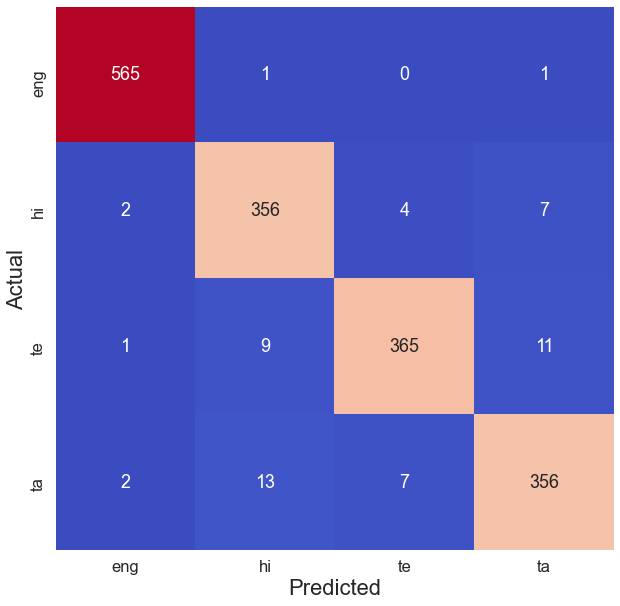

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix

x_test = test_feat.drop('lang',axis=1)
y_test = test_feat['lang']

#Get predictions on test set
labels = model.predict_classes(x_test)
predictions = encoder.inverse_transform(labels)

#Accuracy on test set
accuracy = accuracy_score(y_test,predictions)
print(accuracy)

#Create confusion matrix
lang = ['eng', 'hi', 'te', 'ta']
conf_matrix = confusion_matrix(y_test,predictions)
conf_matrix_df = pd.DataFrame(conf_matrix,columns=lang,index=lang)

#Plot confusion matrix heatmap
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df,cmap='coolwarm',annot=True,fmt='.5g',cbar=False)
plt.xlabel('Predicted',fontsize=22)
plt.ylabel('Actual',fontsize=22)

In [50]:
X = vectorizer.fit_transform(['appudu vichithrangha aa shishuvu adrushayamaina athanni samharinchagala shishuvu marekado peruguthunadani'])
#print(X)
print(lang[model.predict_classes(X)[0]])

te


In [52]:
from flask import Response, Flask, jsonify, request

In [ ]:
app = Flask(__name__)

@app.route('/detect_lang', methods=['GET'])
def detect_lang():
    utterance = request.args.get('utterance')
    print(utterance)
    X = vectorizer.fit_transform([utterance])
    if model.predict_classes(X)[0] == 0:
        return "en"
    elif model.predict_classes(X)[0] == 1:
        return "hi"
    elif model.predict_classes(X)[0] == 2:
        return "ta"
    else:
        return "te"
    
if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 5001, app)

 * Running on http://localhost:5001/ (Press CTRL+C to quit)
127.0.0.1 - - [06/Nov/2020 18:40:38] "GET /detect_lang?utterance=kidaikodukalin%20munaigal%20irupuramum%20kuthuk%20kodukalal%20inaikkappattiru HTTP/1.1" 200 -


kidaikodukalin munaigal irupuramum kuthuk kodukalal inaikkappattiru


127.0.0.1 - - [26/Nov/2020 23:02:02] "GET /detect_lang?utterance=kidaikodukalin%20munaigal%20irupuramum%20kuthuk%20kodukalal%20inaikkappattiru HTTP/1.1" 200 -


kidaikodukalin munaigal irupuramum kuthuk kodukalal inaikkappattiru
